# ライブラリ

In [1]:
import os, time, copy, pickle
import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

# 変数

In [2]:
num_users = 100
num_classes = 10
epochs = 10
frac = 0.1
local_batch_size = 10
local_epoch_size = 10
lr = 0.01

# データセット読み込み

In [3]:
data_dir = './cifar10/'
apply_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.CIFAR10(data_dir, train=False, download=True, transform=apply_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def cifar_iid(dataset, num_users):
    num_items = int(len(dataset)/num_users)
    dict_users = {}
    all_idxs = [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

user_groups = cifar_iid(train_dataset, num_users)

# def cifar_noniid(dataset, num_users):
#     num_shards, num_imgs = 200, 250
#     idx_shard = [i for i in range(num_shards)]
#     dict_users = {i: np.array([]) for i in range(num_users)}
#     idxs = np.arange(num_shards * num_imgs)
#     labels = np.array(dataset.train_labels)

#     idxs_labels = np.vstack((idxs, labels))
#     idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
#     idxs = idxs_labels[0, :]

#     for i in range(num_users):
#         rand_set = set(np.random.choice(idx_shard, 2, replace=False))
#         idx_shard = list(set(idx_shard) - rand_set)
#         for rand in rand_set:
#             dict_users[i] = np.concatenate((dict_users[i], idxs[rand * num_imgs:(rand + 1) * num_imgs]), axis=0)
#     return dict_users

# user_groups = cifar_noniid(train_dataset, num_users)

# モデル

In [5]:
class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # 全結合層の大きさにリサイズ
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# データ処理

In [6]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)
    
class LocalUpdate(object):
    def __init__(self, dataset, idxs):
        self.trainloader, self.validloader, self.testloader = self.train_val_test(dataset, list(idxs))
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.criterion = nn.NLLLoss().to(self.device)

    def train_val_test(self, dataset, idxs):
        idxs_train = idxs[:int(0.8 * len(idxs))]
        idxs_val = idxs[int(0.8 * len(idxs)):int(0.9 * len(idxs))]
        idxs_test = idxs[int(0.9 * len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train), batch_size=local_batch_size, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val), batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test), batch_size=int(len(idxs_test)/10), shuffle=False)
        return trainloader, validloader, testloader

    def update_weights(self, model):
        model.train()
        epoch_loss = []
        
        optimizer = torch.optim.SGD(model.parameters(), lr=lr) # momentum=0.5 ?

        for iter in range(local_epoch_size):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.trainloader):
                images, labels = images.to(self.device), labels.to(self.device)

                model.zero_grad()
                log_probs = model(images)
                loss = self.criterion(log_probs, labels)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return model.state_dict(), sum(epoch_loss) / len(epoch_loss)
    
    def inference(self, model):
        model.eval()
        loss, total, correct = 0.0, 0.0, 0.0

        for batch_idx, (images, labels) in enumerate(self.testloader):
            images, labels = images.to(self.device), labels.to(self.device)

            outputs = model(images)
            batch_loss = self.criterion(outputs, labels)
            loss += batch_loss.item()

            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)

        accuracy = correct/total
        return accuracy, loss

# 勾配の平均

In [7]:
def average_weights(w):
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

# テスト評価

In [8]:
def test_inference(model, test_dataset):
    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct / total
    return accuracy, loss

# main

  0%|          | 0/10 [00:00<?, ?it/s]/home/tsuchiya/.anyenv/envs/pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 10/10 [02:32<00:00, 15.20s/it]


 
 Results after 10 global rounds of training:
|---- Avg Train Accuracy: 48.00%
|---- Test Accuracy: 45.09%


Text(0.5,0,'Communication Rounds')

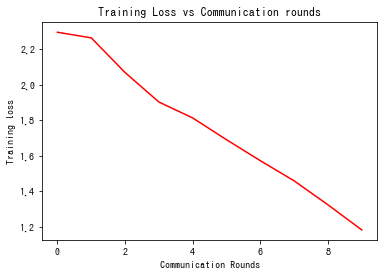

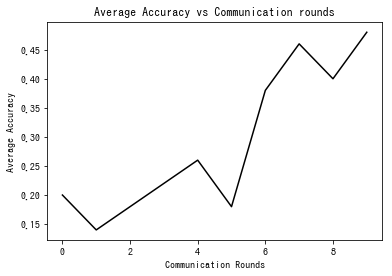

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

global_model = CNNCifar()
global_model.to(device)
global_model.train()

# copy weights
global_weights = global_model.state_dict()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0

for epoch in tqdm(range(epochs)):
    local_weights, local_losses = [], []

    global_model.train()
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace=False)
    
    # ローカルの学習
    for idx in idxs_users:
        local_model = LocalUpdate(dataset=train_dataset, idxs=user_groups[idx])
        w, loss = local_model.update_weights(model=copy.deepcopy(global_model))
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    # 勾配の平均を計算
    global_weights = average_weights(local_weights)
    # グローバルモデルの更新
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(num_users):
        local_model = LocalUpdate(dataset=train_dataset, idxs=user_groups[idx])
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))

test_acc, test_loss = test_inference(global_model, test_dataset)

print(f' \n Results after {epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100 * test_acc))
    
plt.figure()
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')

plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')

# 通常モデル

100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


Test Accuracy: 53.15%


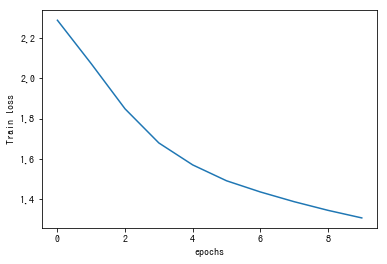

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

basic_model = CNNCifar()
basic_model.to(device)
basic_model.train()

optimizer = torch.optim.SGD(basic_model.parameters(), lr=lr)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
criterion = torch.nn.NLLLoss().to(device)
epoch_loss = []

for epoch in tqdm(range(epochs)):
    batch_loss = []

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = basic_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
    loss_avg = sum(batch_loss)/len(batch_loss)
    epoch_loss.append(loss_avg)

# Plot loss
plt.figure()
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel('epochs')
plt.ylabel('Train loss')

# testing
test_acc, test_loss = test_inference(basic_model, test_dataset)
print("Test Accuracy: {:.2f}%".format(100*test_acc))

Text(0.5,0,'Iter')

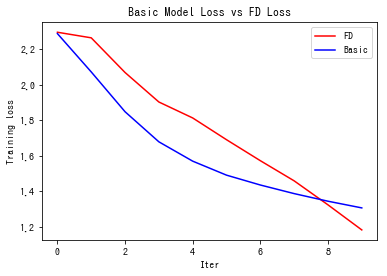

In [11]:
plt.figure()
plt.title('Basic Model Loss vs FD Loss')
plt.plot(range(len(train_loss)), train_loss, color='r', label='FD')
plt.plot(range(len(epoch_loss)), epoch_loss, color='b', label='Basic')
plt.legend()
plt.ylabel('Training loss')
plt.xlabel('Iter')